# Alpaca Paper Trading — Mean Reversion Strategy

**Three operating modes:**
1. **Replay Mode** — Replay historical data day-by-day through the live pipeline. Validates that live system matches backtest results.
2. **Shadow Mode** — Run on live Alpaca data but don't submit orders. Track hypothetical P&L. Build confidence before going live.
3. **Live Mode** — Submit real paper-trade orders to Alpaca.

**Workflow:**
- Cell 1–3: Setup, connection, universe selection
- Cell 4–5: Data fetch + signal generation (shared by all modes)
- Cell 5c: **Shadow Replay** — 1-year performance evaluation
- Cell 6–7: **Mode A: Replay** — historical validation + backtest comparison
- Cell 8: **Mode B: Shadow / Live** — daily trading execution
- Cell 9–10: Position dashboard + trade log export

> **Crypto test:** See `main_crypto_test.ipynb` for BTC/ETH live order validation.

In [1]:
# ══════════════════════════════════════════════════════════════════════════════
# CELL 1: IMPORTS & SETUP
# ══════════════════════════════════════════════════════════════════════════════

import sys, os, time, logging, importlib
from pathlib import Path
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ensure src/ is on the path
src_dir = Path.cwd() if Path.cwd().name == 'src' else Path.cwd() / 'src'
if str(src_dir) not in sys.path:
    sys.path.insert(0, str(src_dir))

# ─── Strategy & backtest modules ───────────────────────────────────────────
from strategy_config import ConfigLoader
from strategies.mean_reversion import MeanReversionSignals, SignalConfig
from backtest.engine import BacktestEngine, BacktestConfig

# ─── Alpaca modules ────────────────────────────────────────────────────────
from connection.alpaca_connection import AlpacaConfig, AlpacaConnection, TradingMode
from data.alpaca_data import AlpacaDataAdapter
from execution.alpaca_executor import AlpacaExecutor, TradeDecision, TradeResult
from execution.simulation import SimulationEngine

# ─── Shared trading pipeline ──────────────────────────────────────────────
from trading.pipeline import (
    select_universe, refresh_universe_hurst,
    fetch_data, generate_signals,
    build_executor, build_simulation,
)
from trading.analysis import (
    plot_shadow_replay, print_monthly_returns, print_trade_summary,
    print_metrics_comparison, print_replay_trade_breakdown,
    plot_equity_comparison, plot_export_charts,
)
from trading.dashboard import show_dashboard

# ─── Logging ───────────────────────────────────────────────────────────────
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s | %(name)s | %(levelname)s | %(message)s',
    datefmt='%H:%M:%S'
)

# ─── Load config ───────────────────────────────────────────────────────────
config = ConfigLoader()
signal_config = config.to_signal_config()
bt_config = config.to_backtest_config()
composite_weights = config.get_composite_weights()

print("✅ All modules loaded")
print(f"   Signal mode: {signal_config.signal_mode}")
print(f"   Kalman: {'ON' if signal_config.use_kalman else 'OFF'}")
print(f"   OU Gate: {'ON' if signal_config.use_predicted_return else 'OFF'}")
print(f"   Entry threshold: {bt_config.entry_threshold}")
print(f"   Exit threshold:  {bt_config.exit_threshold}")
print(f"   Stop loss: {bt_config.stop_loss_pct}")
print(f"   Max hold:  {bt_config.max_holding_days} days")

✅ All modules loaded
   Signal mode: gated
   Kalman: ON
   OU Gate: ON
   Entry threshold: 1.43
   Exit threshold:  0.5
   Stop loss: 0.1
   Max hold:  20 days


In [3]:
# ══════════════════════════════════════════════════════════════════════════════
# CELL 1b: CONFIG F PARAMETER OVERRIDE (Recommended by deep dive analysis)
# ══════════════════════════════════════════════════════════════════════════════
# Config F: entry=1.0, pos_size=15%, hold=5d (Sharpe 5.19, +118.7%, MaxDD -5.41%)
# Toggle APPLY_CONFIG_F to quickly switch between current deployed and recommended.

APPLY_CONFIG_F = True  # ← Set False to use current deployed params

if APPLY_CONFIG_F:
    # ─── Override backtest config ──────────────────────────────────────────
    bt_config.entry_threshold = 1.0      # was 1.43
    bt_config.max_position_size = 0.15   # was 0.10
    bt_config.max_holding_days = 5       # was 20

    # ─── Also update volatility_scaling max_size to match ──────────────────
    # (volatility_scaled sizing caps at max_size, should match max_position_size)
    config.config['backtest']['volatility_scaling']['max_size'] = 0.15

    print("🔧 CONFIG F OVERRIDE APPLIED:")
    print(f"   entry_threshold:  1.43 → {bt_config.entry_threshold}")
    print(f"   max_position_size: 0.10 → {bt_config.max_position_size}")
    print(f"   max_holding_days:  20 → {bt_config.max_holding_days}")
    print(f"   vol_scaling max:   0.10 → 0.15")
    print(f"   (stop_loss, exit_threshold, take_profit unchanged)")
else:
    print("ℹ️  Using current deployed parameters (no override)")
    print(f"   entry_threshold:  {bt_config.entry_threshold}")
    print(f"   max_position_size: {bt_config.max_position_size}")
    print(f"   max_holding_days:  {bt_config.max_holding_days}")

🔧 CONFIG F OVERRIDE APPLIED:
   entry_threshold:  1.43 → 1.0
   max_position_size: 0.10 → 0.15
   max_holding_days:  20 → 5
   vol_scaling max:   0.10 → 0.15
   (stop_loss, exit_threshold, take_profit unchanged)


In [4]:
# ══════════════════════════════════════════════════════════════════════════════
# CELL 2: CONNECT TO ALPACA
# ══════════════════════════════════════════════════════════════════════════════
# Set trading mode here:
#   TradingMode.REPLAY  — historical replay (no API calls for orders)
#   TradingMode.SHADOW  — live data, simulated trades
#   TradingMode.LIVE    — submit real paper-trade orders

TRADING_MODE = TradingMode.SHADOW  # ← Change this as needed

# Load API keys from .env and create connection
alpaca_config = AlpacaConfig.from_env()
alpaca_config.trading_mode = TRADING_MODE

conn = AlpacaConnection(alpaca_config)
conn.test_connection()

print(f"\n🔧 Trading mode: {TRADING_MODE.value.upper()}")
if TRADING_MODE == TradingMode.REPLAY:
    print("   → Using historical data only. No Alpaca API orders.")
elif TRADING_MODE == TradingMode.SHADOW:
    print("   → Live data, simulated trades. No real orders submitted.")
else:
    print("   → ⚠️  LIVE MODE: Real paper-trade orders will be submitted!")

22:24:42 | connection.alpaca_connection | INFO | Trading client initialized (paper=True, mode=shadow)


  ALPACA CONNECTION TEST
  Status:          AccountStatus.ACTIVE
  Mode:            PAPER
  Trading Mode:    SHADOW
  Cash:            $903,911.76
  Buying Power:    $1,904,279.84
  Portfolio Value: $1,000,392.00
  Market Open:     False
  Day Trades:      0
  PDT Flag:        False

🔧 Trading mode: SHADOW
   → Live data, simulated trades. No real orders submitted.


In [5]:
# ══════════════════════════════════════════════════════════════════════════════
# CELL 3: SELECT TOP-60 UNIVERSE
# ══════════════════════════════════════════════════════════════════════════════

MAX_UNIVERSE = config.get('alpaca.max_universe_size', 60)

UNIVERSE = select_universe(config, max_symbols=MAX_UNIVERSE)

print(f"📊 Trading Universe ({len(UNIVERSE)} symbols):")
for i in range(0, len(UNIVERSE), 10):
    print(f"   {', '.join(UNIVERSE[i:i+10])}")

22:24:50 | trading.pipeline | INFO | Loaded Hurst cache → 60 symbols


📊 Trading Universe (60 symbols):
   TRV, SPGI, ABNB, HURN, IBM, VZ, TENB, TMUS, INTU, APD
   LIN, CRM, LOW, CENTA, CNS, BIDU, SKYW, CSWI, PG, BKNG
   DASH, PLD, ROP, ADP, ANSS, AGM, UNH, T, CTSH, CHTR
   ENSG, ASTE, VSEC, DIS, BA, MO, JNJ, TXN, TEAM, ECL
   ZS, META, NTES, NHC, LULU, GTES, SFNC, ICFI, MPWR, ACN
   QTWO, UNP, MA, DY, KO, EOG, PYPL, COST, ALKT, SYK


In [6]:
# ══════════════════════════════════════════════════════════════════════════════
# CELL 4: FETCH DATA — MODE-AWARE CACHING
# ══════════════════════════════════════════════════════════════════════════════

# Adjust lookback based on mode
if TRADING_MODE == TradingMode.REPLAY:
    LOOKBACK_DAYS = 1825  # Full history for replay validation
    ALLOW_STALE_CACHE = False  # Replay needs fresh data, not stale cache
else:
    LOOKBACK_DAYS = 500   # Just need recent data for signals
    ALLOW_STALE_CACHE = True  # Shadow/Live can use recent cache

adapter = AlpacaDataAdapter(
    data_client=conn.data_client,
    data_feed=alpaca_config.data_feed,
    cache_dir=Path('../data/snapshots/alpaca_cache'),
)

print(f"Loading data for {len(UNIVERSE)} symbols ({TRADING_MODE.value.upper()} mode)...")
print(f"  Lookback: {LOOKBACK_DAYS} days (~{LOOKBACK_DAYS/365:.1f} years)")
print(f"  Data feed: {alpaca_config.data_feed.upper()}")
print(f"  Stale cache: {'ALLOWED (up to 3 days)' if ALLOW_STALE_CACHE else 'NOT ALLOWED'}")

t0 = time.perf_counter()
price_df, volume_df, raw_bars = fetch_data(
    adapter, UNIVERSE,
    lookback_days=LOOKBACK_DAYS,
    allow_stale_cache=ALLOW_STALE_CACHE,
)
elapsed = time.perf_counter() - t0

trading_days = len(price_df)
trading_years = trading_days / 252

print(f"\n✅ Data ready in {elapsed:.1f}s")
print(f"   Date range : {price_df.index.min().date()} → {price_df.index.max().date()}")
print(f"   Trading days: {trading_days}  (~{trading_years:.1f} years)")
print(f"   Symbols OK  : {len(price_df.columns)}")
missing = set(UNIVERSE) - set(price_df.columns)
if missing:
    print(f"   Missing     : {', '.join(sorted(missing))}")
else:
    print(f"   Missing     : none")

# Update universe to only symbols with valid data
UNIVERSE = list(price_df.columns)

22:25:00 | connection.alpaca_connection | INFO | Data client initialized


Loading data for 60 symbols (SHADOW mode)...
  Lookback: 500 days (~1.4 years)
  Data feed: IEX
  Stale cache: ALLOWED (up to 3 days)


22:25:01 | data.alpaca_data | INFO | Loaded 60 symbols from cache
22:25:01 | trading.pipeline | INFO | Cache is 0.0d old, 60/60 symbols (100% coverage) — loading from disk



✅ Data ready in 0.7s
   Date range : 2024-10-07 → 2026-02-18
   Trading days: 342  (~1.4 years)
   Symbols OK  : 60
   Missing     : none


In [7]:
# ══════════════════════════════════════════════════════════════════════════════
# CELL 5: GENERATE SIGNALS
# ══════════════════════════════════════════════════════════════════════════════

print(f"Generating signals for {len(UNIVERSE)} symbols...")
t0 = time.perf_counter()

signal_df, zscore_df = generate_signals(config, price_df, volume_df)

# Align price/volume to signal index
price_df = price_df.loc[signal_df.index, signal_df.columns]
volume_df = volume_df.loc[signal_df.index, signal_df.columns]

elapsed = time.perf_counter() - t0
print(f"✅ Signals generated for {len(signal_df.columns)} symbols in {elapsed:.1f}s")

# Show today's signals snapshot
latest_date = signal_df.index[-1]
latest_signals = signal_df.loc[latest_date].dropna().sort_values()
print(f"\n📡 Latest signals ({latest_date.date()}):")
print(f"   Strong longs  (signal < -{bt_config.entry_threshold}): "
      f"{(latest_signals < -bt_config.entry_threshold).sum()}")
print(f"   Strong shorts (signal > +{bt_config.entry_threshold}): "
      f"{(latest_signals > bt_config.entry_threshold).sum()}")
print(f"   Signal range: [{latest_signals.min():.2f}, {latest_signals.max():.2f}]")

Generating signals for 60 symbols...
✅ Signals generated for 60 symbols in 1.1s

📡 Latest signals (2026-02-18):
   Strong longs  (signal < -1.0): 0
   Strong shorts (signal > +1.0): 0
   Signal range: [0.00, 0.00]


## Shadow Replay — 1-Year Performance

Runs the SHADOW execution pipeline over the last 252 trading days (~1 year) to observe how trades would have performed historically. Uses the same signal generation, entry/exit logic, and position sizing as daily shadow mode, but replayed over the full year.

🔮 SHADOW REPLAY — 1-Year Performance Evaluation
───────────────────────────────────────────────────────
   Period  : 2025-02-18 → 2026-02-18  (252d)
   Capital : $100,000  |  Universe: 60 symbols


  HISTORICAL REPLAY
  Period: 2025-02-18 → 2026-02-18 (252 days)
  Universe: 60 symbols
  Initial Capital: $100,000

  Day 250/252 | 2026-02-13 | Equity: $188,229 (+88.2%) | Positions: 2 | Trades: 1022

  SIMULATION RESULTS
  Final Equity:    $187,750.81
  Total Return:    +87.86%
  Sharpe Ratio:    4.95
  Max Drawdown:    -6.45%
  Total Trades:    1024
  Win Rate:        61.9%
  Avg Trade P&L:   +0.73%
  Avg Winner:      +2.03%
  Avg Loser:       -1.39%
  Open Positions:  0

⏱️  Completed in 1.1s
📊 Chart saved → ../data/snapshots/shadow_replay_1yr.png


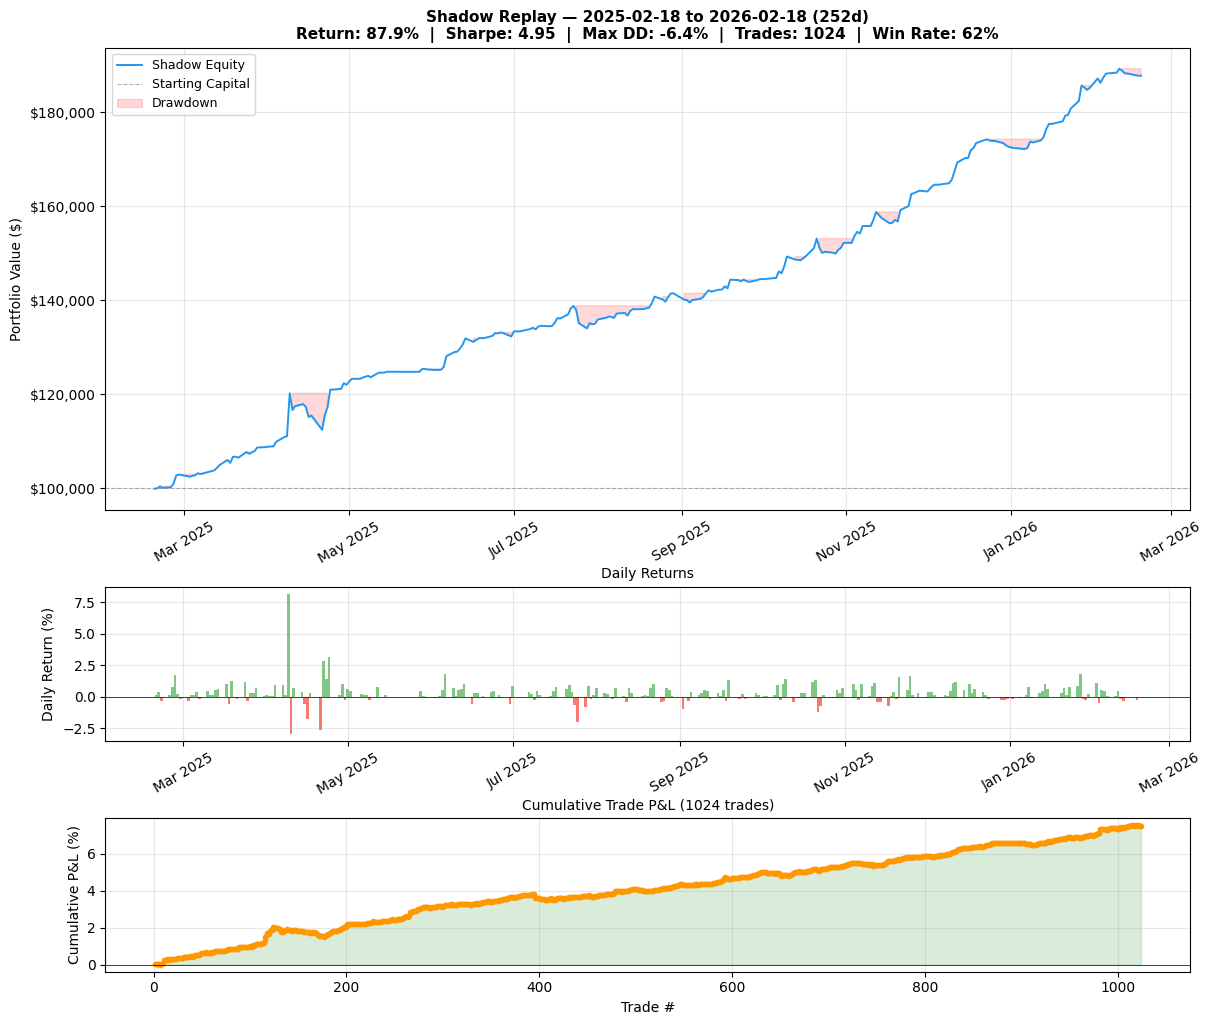


📅 Monthly Returns:
────────────────────────────────────────
   2025-02  🟢 +  2.89%  █████
   2025-03  🟢 +  5.78%  ███████████
   2025-04  🟢 + 12.19%  ████████████████████████
   2025-05  🟢 +  2.67%  █████
   2025-06  🟢 +  5.61%  ███████████
   2025-07  🟢 +  2.05%  ████
   2025-08  🟢 +  4.78%  █████████
   2025-09  🟢 +  2.15%  ████
   2025-10  🟢 +  5.32%  ██████████
   2025-11  🟢 +  7.28%  ██████████████
   2025-12  🟢 +  5.71%  ███████████
   2026-01  🟢 +  7.25%  ██████████████
   2026-02  🟢 +  1.40%  ██
────────────────────────────────────────
   Total       +65.09%

📋 Top/Bottom Trades:
─────────────────────────────────────────────────────────────────
   Best:
     LULU   short   +0.21%  2025-06-04 → 2025-06-06
     UNH    short   +0.21%  2026-01-23 → 2026-01-27
     BA     long    +0.18%  2025-04-04 → 2025-04-09
     ASTE   long    +0.16%  2025-02-24 → 2025-02-26
     ZS     long    +0.15%  2025-04-04 → 2025-04-09
   Worst:
     BKNG   long    -0.07%  2025-11-14 → 2025-11-19
     RO

In [8]:
# ══════════════════════════════════════════════════════════════════════════════
# CELL 5c: 1-YEAR SHADOW REPLAY
# ══════════════════════════════════════════════════════════════════════════════

shadow_replay_executor = build_executor(conn, bt_config, TradingMode.SHADOW)
shadow_replay_sim = build_simulation(shadow_replay_executor, bt_config, TradingMode.SHADOW)

# ─── 1-year window ────────────────────────────────────────────────────────
REPLAY_WINDOW = 252
shadow_start = signal_df.index[-REPLAY_WINDOW] if len(signal_df) > REPLAY_WINDOW else signal_df.index[0]
shadow_end = signal_df.index[-1]
trading_days = len(signal_df.loc[shadow_start:shadow_end])

print(f"🔮 SHADOW REPLAY — 1-Year Performance Evaluation")
print(f"{'─'*55}")
print(f"   Period  : {shadow_start.date()} → {shadow_end.date()}  ({trading_days}d)")
print(f"   Capital : ${bt_config.initial_capital:,.0f}  |  Universe: {len(UNIVERSE)} symbols\n")

t0 = time.perf_counter()
shadow_replay_results = shadow_replay_sim.run_replay(
    price_df=price_df, signal_df=signal_df, volume_df=volume_df,
    exit_signal_df=zscore_df, config=bt_config,
    start_date=shadow_start, end_date=shadow_end, verbose=True,
)
print(f"\n⏱️  Completed in {time.perf_counter() - t0:.1f}s")

# ─── Charts & reports (from trading.analysis) ─────────────────────────────
plot_shadow_replay(
    shadow_replay_results, bt_config, shadow_start, shadow_end,
    n_symbols=len(UNIVERSE),
    save_path=Path('../data/snapshots/shadow_replay_1yr.png'),
)
print_monthly_returns(shadow_replay_results.get('returns'))
print_trade_summary(shadow_replay_results.get('trades_df'))

## Mode A: Historical Replay

Replays historical data day-by-day through the live pipeline. Validates that the live execution system produces the same signals and trades as the backtest engine. Run this once before trusting the live system.

In [9]:
# ══════════════════════════════════════════════════════════════════════════════
# CELL 6: HISTORICAL REPLAY — MAXIMUM WINDOW
# ══════════════════════════════════════════════════════════════════════════════

# Create executor+sim in REPLAY mode
replay_config = AlpacaConfig.from_env()
replay_config.trading_mode = TradingMode.REPLAY
replay_conn = AlpacaConnection(replay_config)

replay_executor = build_executor(replay_conn, bt_config, TradingMode.REPLAY)
sim = build_simulation(replay_executor, bt_config, TradingMode.REPLAY)

# ── Use ALL available data (skip first 100 days for signal warmup) ──
# Kalman filter converges in ~20-50 days; 100 days is conservative enough.
WARMUP_DAYS = 100
replay_start = signal_df.index[WARMUP_DAYS] if len(signal_df) > WARMUP_DAYS else signal_df.index[0]
replay_end = signal_df.index[-1]
replay_trading_days = len(signal_df.loc[replay_start:replay_end])
replay_years = replay_trading_days / 252

print(f"🔄 Running replay over MAXIMUM available window:")
print(f"   Period     : {replay_start.date()} → {replay_end.date()}")
print(f"   Days       : {replay_trading_days}  (~{replay_years:.1f} years)")
print(f"   Capital    : ${bt_config.initial_capital:,.0f}")
print(f"   Warmup     : {WARMUP_DAYS}d (Kalman converges in ~20-50d)")
print()

t0 = time.perf_counter()
replay_results = sim.run_replay(
    price_df=price_df, signal_df=signal_df, volume_df=volume_df,
    exit_signal_df=zscore_df, config=bt_config,
    start_date=replay_start, end_date=replay_end, verbose=True,
)
print(f"\n⏱️  Replay completed in {time.perf_counter() - t0:.1f}s")

🔄 Running replay over MAXIMUM available window:
   Period     : 2025-03-04 → 2026-02-18
   Days       : 242  (~1.0 years)
   Capital    : $100,000
   Warmup     : 100d (Kalman converges in ~20-50d)


  HISTORICAL REPLAY
  Period: 2025-03-04 → 2026-02-18 (242 days)
  Universe: 60 symbols
  Initial Capital: $100,000


  SIMULATION RESULTS
  Final Equity:    $182,945.61
  Total Return:    +83.03%
  Sharpe Ratio:    4.88
  Max Drawdown:    -6.48%
  Total Trades:    1004
  Win Rate:        61.9%
  Avg Trade P&L:   +0.72%
  Avg Winner:      +2.01%
  Avg Loser:       -1.38%
  Open Positions:  0

⏱️  Replay completed in 1.0s


Running backtest on same period for comparison...

════════════════════════════════════════════════════════════════════════
  METRIC                         REPLAY (Live Pipe)            BACKTEST
════════════════════════════════════════════════════════════════════════
  Period                         2025-03-04 → 2026-02-18  2025-03-04 → 2026-02-18
  Trading Days                                  242                 242
  ─── Returns ───               
  Total Return                              +83.03%             +83.80%
  Annualized Return                         +87.66%             +88.48%
  Final Equity                          $182,945.61         $183,796.31
  ─── Risk ───                  
  Sharpe Ratio                                4.883               4.750
  Sortino Ratio                                 n/a               6.863
  Calmar Ratio                                  n/a              12.537
  Max Drawdown                               -6.48%               7.06%
  Max D

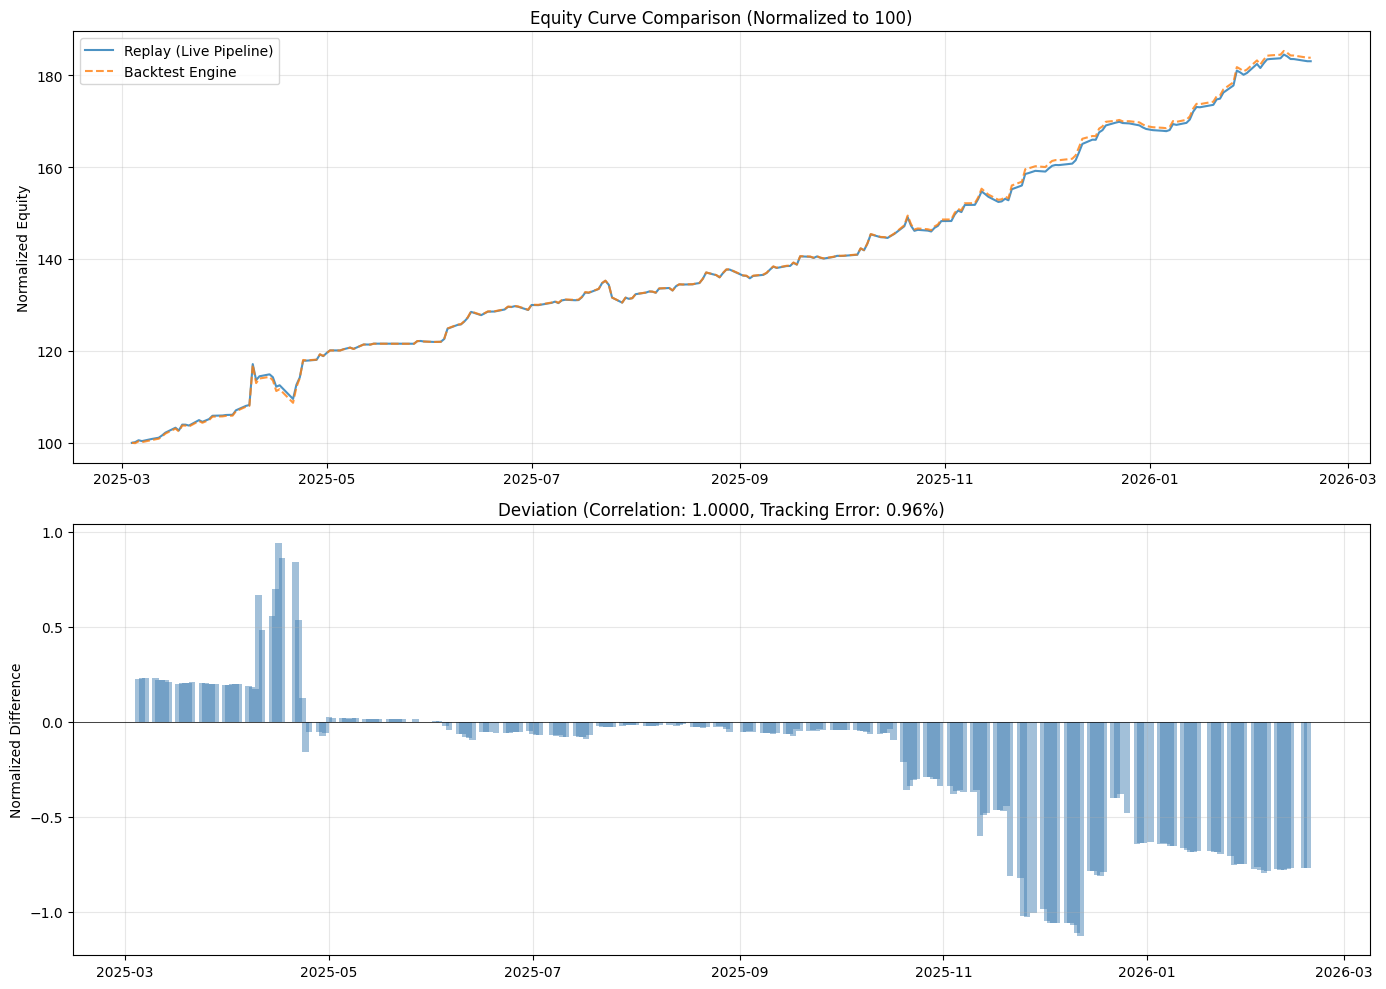


📊 Alignment Metrics:
   Correlation       : 1.0000
   Tracking Error    : 0.96% (annualized)
   Max Deviation     : 1.13
   Avg Deviation     : 0.29
   Overlapping Days  : 242

✅ Strong match! Live pipeline is consistent with backtest.


In [10]:
# ══════════════════════════════════════════════════════════════════════════════
# CELL 7: DETAILED REPLAY vs BACKTEST COMPARISON
# ══════════════════════════════════════════════════════════════════════════════

print("Running backtest on same period for comparison...\n")

bt_engine = BacktestEngine(bt_config)
bt_results = bt_engine.run_backtest(
    price_df.loc[replay_start:],
    signal_df.loc[replay_start:],
    volume_df.loc[replay_start:],
    exit_signal_data=zscore_df.loc[replay_start:],
)

# ─── Side-by-side comparison ──────────────────────────────────────────────
print_metrics_comparison(replay_results, bt_results, replay_start, replay_end)
print_replay_trade_breakdown(replay_results)
plot_equity_comparison(sim, bt_results.equity_curve, replay_results)

## Mode B: Shadow / Live Daily Trading

Run this section daily. In **Shadow mode**, it generates signals and tracks hypothetical trades without submitting orders. In **Live mode**, it submits real paper-trade orders to Alpaca.

**Daily workflow:** Run cells 1–5 (setup + data + signals), then cell 8 below.

In [9]:
# ══════════════════════════════════════════════════════════════════════════════
# CELL 8: DAILY SHADOW / LIVE EXECUTION
# ══════════════════════════════════════════════════════════════════════════════
# Processes today's signals. SHADOW → hypothetical trades. LIVE → real orders.

# ─── Initialize or restore shadow state ────────────────────────────────────
SHADOW_LOG = Path('../data/snapshots/shadow_state.csv')

executor = build_executor(conn, bt_config, TRADING_MODE)
shadow_sim = build_simulation(executor, bt_config, TRADING_MODE)

# Restore previous shadow positions if they exist
if SHADOW_LOG.exists() and TRADING_MODE == TradingMode.SHADOW:
    prev = pd.read_csv(SHADOW_LOG)
    if not prev.empty:
        from execution.simulation import SimulatedPosition
        for _, row in prev.iterrows():
            shadow_sim.positions[row['symbol']] = SimulatedPosition(
                symbol=row['symbol'],
                qty=int(row['qty']),
                side=row['side'],
                entry_price=float(row['entry_price']),
                entry_date=pd.Timestamp(row['entry_date']),
                signal_strength=float(row.get('signal_strength', 0)),
                current_price=float(row.get('current_price', row['entry_price'])),
            )
        shadow_sim.cash -= sum(
            p.entry_price * abs(p.qty) for p in shadow_sim.positions.values()
            if p.side == 'long'
        )
        print(f"♻️  Restored {len(shadow_sim.positions)} shadow positions")

# ─── Process today ─────────────────────────────────────────────────────────
today = signal_df.index[-1]
print(f"\n{'═'*60}")
print(f"  DAILY EXECUTION — {today.date()} — {TRADING_MODE.value.upper()} MODE")
print(f"{'═'*60}")

if TRADING_MODE in (TradingMode.SHADOW, TradingMode.REPLAY):
    shadow_sim.process_shadow_day(
        date=today, signal_df=signal_df, price_df=price_df,
        volume_df=volume_df, exit_signal_df=zscore_df,
        config=bt_config, verbose=True,
    )

    # Save shadow state for next run
    if shadow_sim.positions:
        state_rows = []
        for sym, pos in shadow_sim.positions.items():
            state_rows.append({
                'symbol': pos.symbol, 'qty': pos.qty, 'side': pos.side,
                'entry_price': pos.entry_price, 'entry_date': pos.entry_date,
                'signal_strength': pos.signal_strength,
                'current_price': pos.current_price,
            })
        pd.DataFrame(state_rows).to_csv(SHADOW_LOG, index=False)
        print(f"\n💾 Shadow state saved ({len(state_rows)} positions)")
    else:
        if SHADOW_LOG.exists():
            SHADOW_LOG.unlink()
        print("\n💾 No open positions — shadow state cleared")

else:
    # LIVE mode: generate decisions and submit orders
    current_positions = {}
    for pos in conn.get_positions():
        current_positions[pos['symbol']] = {
            'qty': int(pos['qty']),
            'side': 'long' if int(pos['qty']) > 0 else 'short',
            'entry_price': float(pos['avg_entry_price']),
            'entry_date': pd.Timestamp.now() - pd.Timedelta(days=1),
        }

    decisions = executor.generate_decisions_from_signals(
        signal_df=signal_df, price_df=price_df, volume_df=volume_df,
        exit_signal_df=zscore_df, date=today,
        current_positions=current_positions, config=bt_config,
    )

    if decisions:
        print(f"\n📋 {len(decisions)} trade decisions:")
        for d in decisions:
            print(f"   {d.action.upper():6s} {d.symbol:6s} x{d.target_qty:4d}  "
                  f"signal={d.signal_strength:+.3f}  {d.reason}")

        current_prices = adapter.get_latest_prices([d.symbol for d in decisions])
        results = executor.execute_decisions(decisions, current_prices)

        print(f"\n📊 Execution results:")
        for r in results:
            status_icon = '✅' if r.status in ('filled', 'submitted') else '❌'
            print(f"   {status_icon} {r.decision.symbol} → {r.status} "
                  f"@ ${r.filled_price or 0:.2f}")
    else:
        print("\n😴 No trade signals today")

    account = conn.get_account()
    print(f"\n💰 Account: ${account['portfolio_value']:,.2f} "
          f"(cash: ${account['cash']:,.2f})")


════════════════════════════════════════════════════════════
  DAILY EXECUTION — 2026-02-18 — SHADOW MODE
════════════════════════════════════════════════════════════

── Shadow Day: 2026-02-18 ──
  Equity: $100,000.00 (daily: +0.000%)
  Positions: 0 (0L / 0S)
  Signals > threshold: 0

💾 No open positions — shadow state cleared


## Monitoring & Export

In [10]:
# ══════════════════════════════════════════════════════════════════════════════
# CELL 9: POSITION MONITORING DASHBOARD
# ══════════════════════════════════════════════════════════════════════════════

active_sim = shadow_sim if 'shadow_sim' in dir() else (sim if 'sim' in dir() else None)

show_dashboard(
    sim_engine=active_sim,
    connection=conn,
    mode=TRADING_MODE,
    signal_df=signal_df,
    entry_threshold=bt_config.entry_threshold,
)


══════════════════════════════════════════════════════════════════════
  POSITION DASHBOARD — 2026-02-18 21:02
══════════════════════════════════════════════════════════════════════

  Mode: SHADOW | Equity: $100,000.00 | Cash: $100,000.00
  Open positions: 0
  Completed trades: 0


Equity curve exported: ../data/snapshots/trading_logs/equity_shadow_20260218_2102.csv (1 days)
📈 Equity curve: ../data/snapshots/trading_logs/equity_shadow_20260218_2102.csv


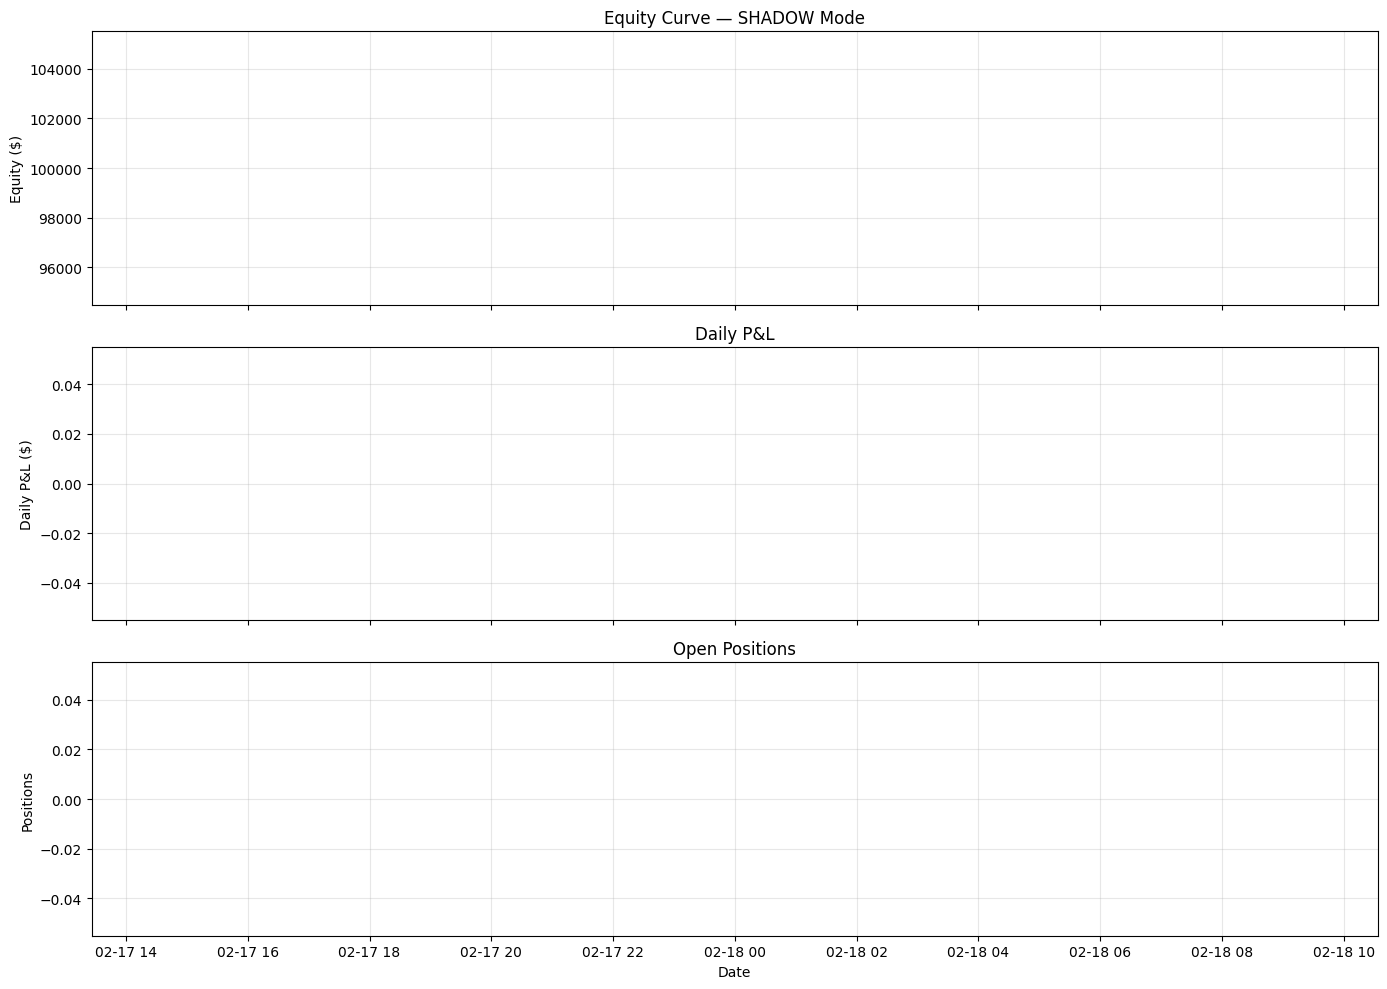

In [11]:
# ══════════════════════════════════════════════════════════════════════════════
# CELL 10: EXPORT TRADE LOGS & EQUITY CURVES
# ══════════════════════════════════════════════════════════════════════════════

export_dir = Path('../data/snapshots/trading_logs')
export_dir.mkdir(parents=True, exist_ok=True)
timestamp = datetime.now().strftime('%Y%m%d_%H%M')

active = shadow_sim if 'shadow_sim' in dir() else (sim if 'sim' in dir() else None)

if active and active.completed_trades:
    trade_path = export_dir / f'trades_{TRADING_MODE.value}_{timestamp}.csv'
    active.export_trade_log(trade_path)
    print(f"📄 Trade log: {trade_path}")

if active and active.daily_snapshots:
    equity_path = export_dir / f'equity_{TRADING_MODE.value}_{timestamp}.csv'
    active.export_equity_curve(equity_path)
    print(f"📈 Equity curve: {equity_path}")

    snapshots_df = pd.DataFrame([
        {'date': s.date, 'equity': s.equity, 'daily_pnl': s.daily_pnl,
         'n_positions': s.n_positions, 'trades_entered': s.trades_entered,
         'trades_exited': s.trades_exited}
        for s in active.daily_snapshots
    ]).set_index('date')

    plot_export_charts(snapshots_df, TRADING_MODE.value)
else:
    print("No trading data to export yet. Run replay or shadow mode first.")